## Motivation {.unnumbered}


Similar to flow cytometry, a common issue with droplet-based single cell sequencing is the capture of multiple cells in a single droplet. The rate of doublet formation depends on the sequencing platform and the number of cells loaded. Below is a reference of doublet detection rate depending on no. of cells loaded during single-cell sequencing with the 10X chromium platform.

![10x Sequencing Doublet Detection Rate](https://kb.10xgenomics.com/hc/article_attachments/360086768291)

Removing doublets is an important step in single-cell analysis to prevent false-positive findings. In the previous chapter, cell multiplexing with hashtag oligo is an effective method to identify and remove <b>homolytic and heterolytic</b> "Doublets", however this requires sequencing of hashtag library which could be costly.

To overcome this issue there currently exists a few methods to identify "Doublets" based on mRNA expression, including DoubletFinder [[McGinnis et al.; 2019]](https://www.sciencedirect.com/science/article/pii/S2405471219300730?via%3Dihub), scDblFinder [[Germain et al, 2022]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9204188/), Scrublet [[Wolock et al.; 2019]](https://www.sciencedirect.com/science/article/pii/S2405471218304745) etc. Many of these algorithms require users to process and cluster the cells prior to doublet prediction, as the identification process typically involves comparing the expressions from each cell to the pseudobulk expression profile of each cluster. These algorithms are effective in predicting <b>heterolytic</b> doublets, as detection works best when the pseudobulk profiles of the clusters are massively different. The pitfall, however, is that when you have a homogenous samples (i.e. FACS-sorted B-/Plasma cells) comprised of <b>homolytic</b> doublets, these detection algorithms may not generate accurate doublet predictions as the pseudobulk profiles of each cluster are similar.

> In our case, our data consist of innate and adaptive immune cells where gene expressions of the major lineages are very different. We will therefore predict doublets using DoubletFinder and scDblFinder to see if it provides addition benefit to remove potential heterolytic doublets. Refering to the table above, each of the samples have ~8k cells captured, therefore doublet rate is 6.4%.

In [1]:
## set up environment
suppressMessages({
source("/camp/home/hungm/working/Matthew/library/R/functions/Seurat/processing.R")
source("/camp/home/hungm/working/Matthew/library/R/functions/Seurat/plotting.R")
setwd("/nemo/lab/caladod/working/Matthew/project/matthew/MH_GSE155224")})

## load seurat objects
obj_list <- qread("seurat/20240826_GSE155224_demux.qs")

In [290]:
## inspect seurat objects
obj_list

$filtered_matrix_1
An object of class Seurat 
17026 features across 7502 samples within 3 assays 
Active assay: HTO (6 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, ADT
 2 dimensional reductions calculated: pca_hto, umap_hto

$filtered_matrix_2
An object of class Seurat 
17299 features across 8227 samples within 3 assays 
Active assay: HTO (6 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, ADT
 2 dimensional reductions calculated: pca_hto, umap_hto


## Calculate Gene Fractions {#sec-calculate_gene_fractions}
  
The function below will perform the calculations of key quality control parameters for every cell but will not filter any cells yet. This is done by calculating the no. of selected reads over the no. of total reads for every cell.

In [ ]:
# run calculate gene fractions if haven't done so already
obj <- calculate_fractions(obj)

## Preprocessing
As mentioned above, we will begin by processing these 2 sequencing runs by merging the seurat objects together and define cell clusters prior to doublet detection.

In [291]:
## merge seurat objects together
obj <- merge(obj_list[[1]], obj_list[2:length(obj_list)])
DefaultAssay(obj) <- "RNA"
obj[["RNA"]] <- JoinLayers(obj[["RNA"]])
obj

An object of class Seurat 
17895 features across 15729 samples within 3 assays 
Active assay: RNA (17697 features, 0 variable features)
 1 layer present: counts
 2 other assays present: HTO, ADT

The wrapper function below will perform library normalization (log1p), feature selection, scaling, principal component analysis (PCA), batch-correction with Harmony (optional), Louvain clustering (res = 0.4) and UMAP projection.

Finding variable features for layer counts

Transposing data matrix

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


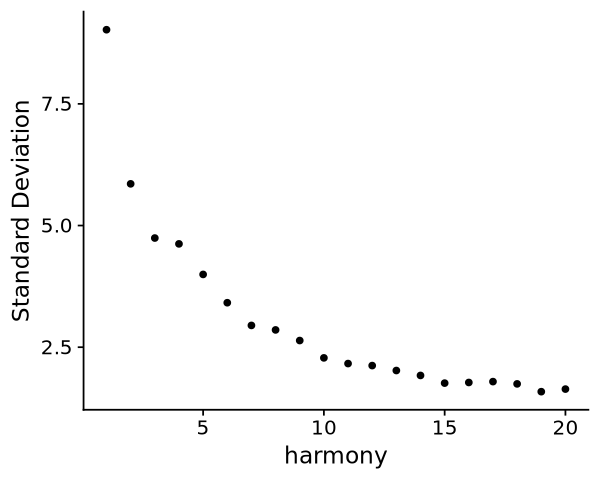

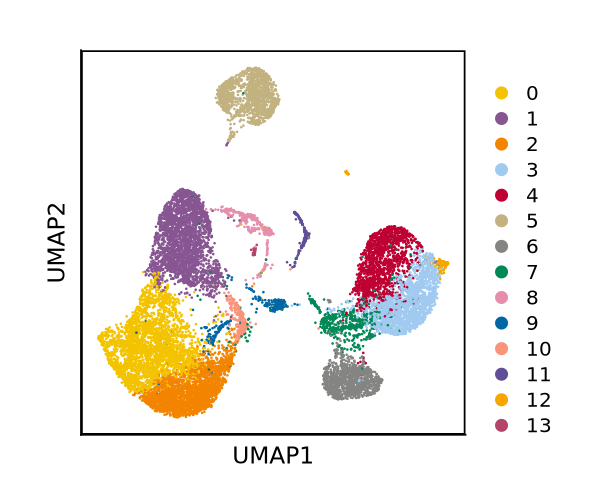

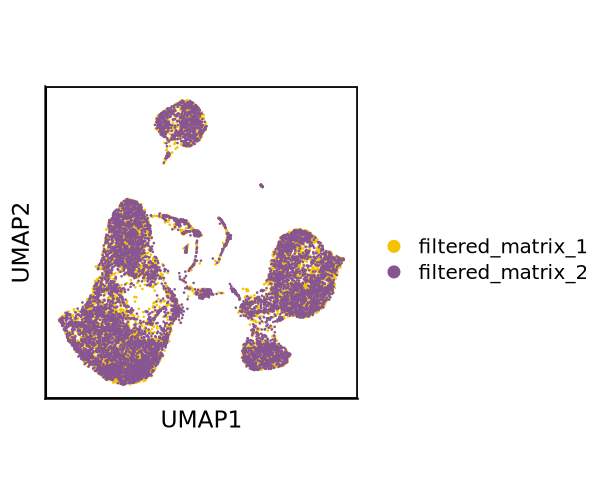

In [292]:
## Run seurat processing steps
options(repr.plot.width=5, repr.plot.height= 4)
obj <- process_seurat(obj, dims = 1:10, harmony = T, group.by.vars = "samples")

## scDblFinder
We will first perform doublet detection with scDblFinder with the wrapper function below. The function will convert Seurat to SingleCellExperiment (SCE) object, run scDblFinder pipeline, and return a Seurat object with scDblFinder outputs stored in Seurat metadata. User can also specify cell demultiplexing results in the \<truth\> argument where the function will input "Singlet" and "Doublet" cells solely for doublet detection.

:::{.callout-warning}
In the case where only certain samples have cell multiplex libraries, users will need to set any "NA" values to "Singlets" for the wrapper function to run properly.
:::

> In the run_scdblfinder() function, we specified cluster labels ("seurat_clusters"), sequencing runs ("samples"), doublet detection rate of 6.4% (dbr) and truth ("MULTI.global"). 

In [293]:
## convert to sce and run scDblFinder
obj <- run_scdblfinder(obj, clusters = "seurat_clusters", samples = "samples", truth = "MULTI.global", dbr=0.064, ncores = 30)

Warning message:
“Assay RNA changing from Assay5 to Assay”


Below we visualize the outputs of scDblFinder with MULTIseqDemux cell demultiplexing outputs and known characteristics of doublets (high nCount_RNA/HTO).

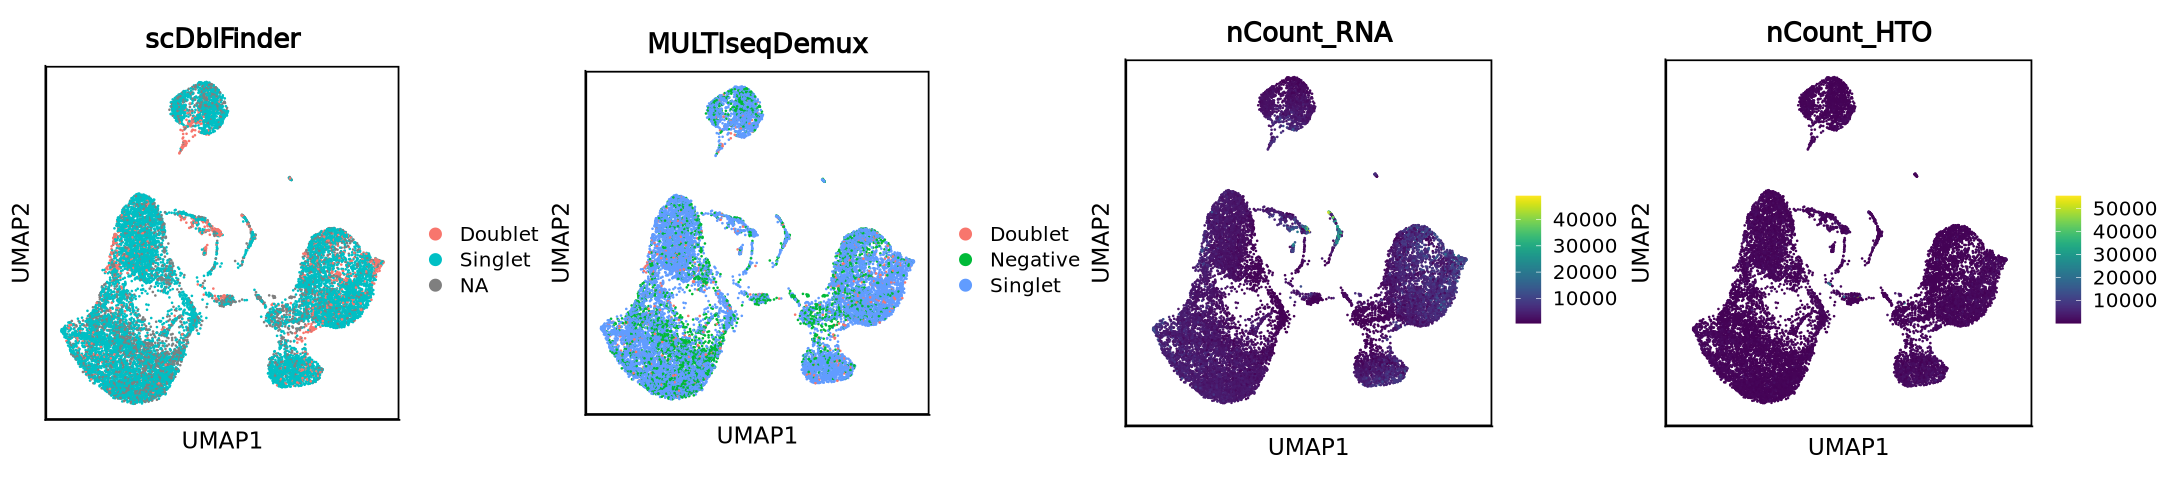

In [294]:
## visualize scDblFinder output
options(repr.plot.width=18, repr.plot.height= 4)
plist <- list(scUMAP(obj, reduction = "umap", group.by = "scDblFinder") + ggtitle("scDblFinder"))
plist[[2]] <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global") + ggtitle("MULTIseqDemux")
plist[3:4] <- scFeaturePlot(obj, reduction = "umap", features = c("nCount_RNA", "nCount_HTO"), ncol = 2)
plot_grid(plotlist = plist, ncol = 4)

> Compare to the cell demultiplexing outputs, scDblFinder detects and extra 926 doublets based on transcriptomic profile.

In [295]:
## compare cell multiplexing output (truth) to scDblFinder output (call)
table(truth=obj$MULTI.global, call=obj$scDblFinder)

          call
truth      Doublet Singlet
  Doublet      213     409
  Negative       0       0
  Singlet      929   10759

> scDblFinder found 7.2% doublets (1139 cells) across the 2 sequencing runs.

In [296]:
## no. / percentage of doublets
no <- length(which(obj$scDblFinder == "Doublet"))
no
paste0(round(no*100/ncol(obj), 1), "%")

[1] 1142

[1] "7.3%"

Visualizing quality control parameters for singlets and doublets detected by scDblFinder.

> Doublets detected have higher nFeature_RNA & nCount_RNA than singlets, reflecting the nature of true doublets.

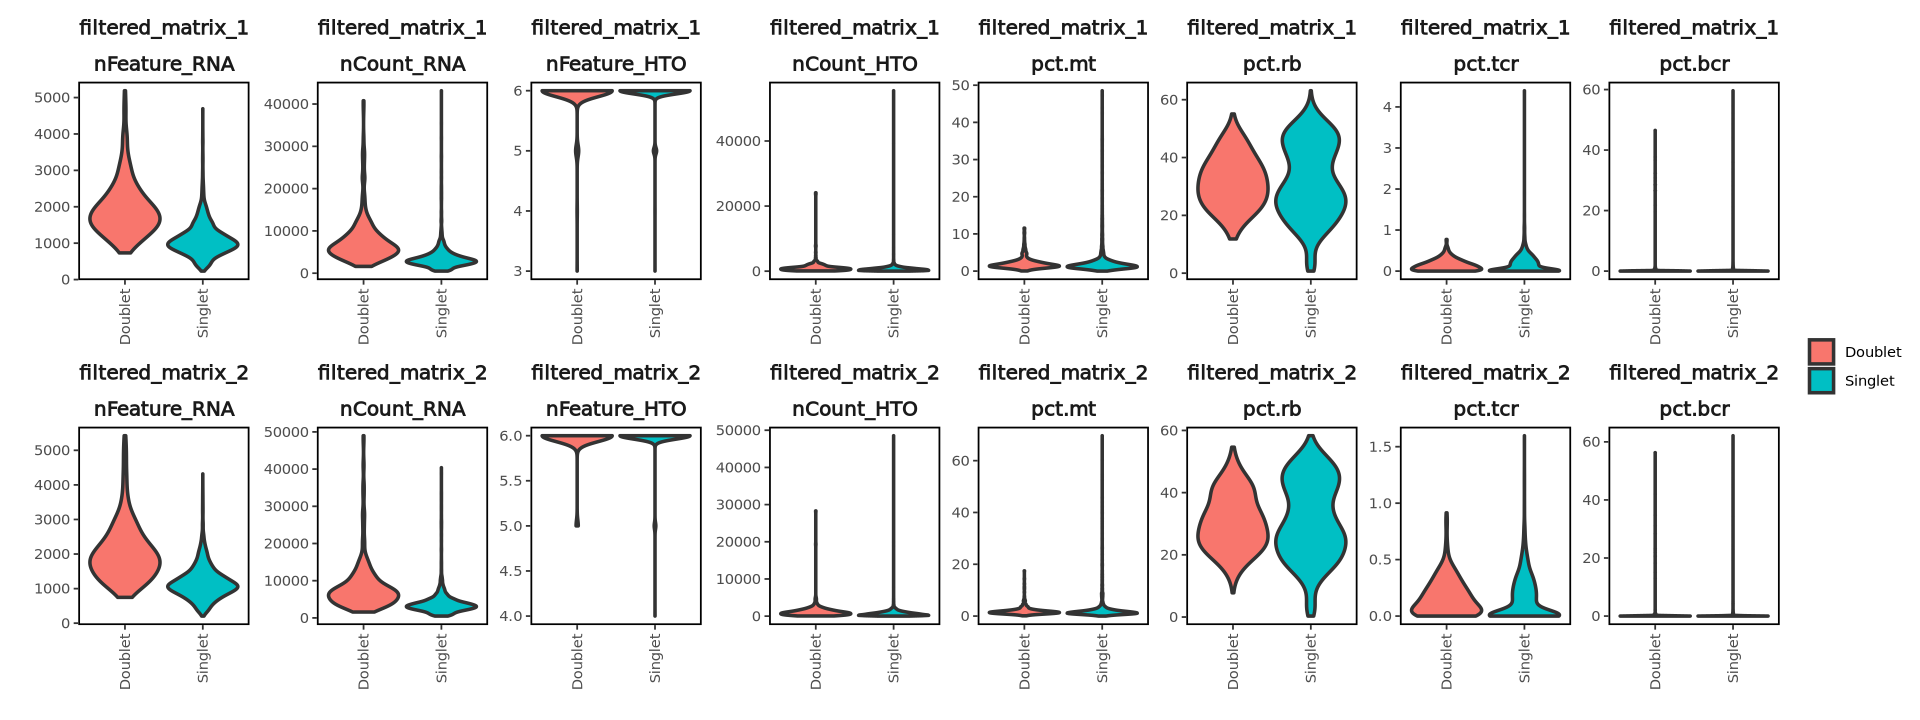

In [297]:
## Visualize qc metrics for doublets detected by scDblFinder
options(repr.plot.width=16, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    filter(!is.na(scDblFinder)) %>%
    ggplot(aes(x = scDblFinder, y = values, fill = scDblFinder)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## DoubletFinder
Continuing from scDblFinder, we will split the merged Seurat object into a list of objects by sequencing runs in order to perform the DoubletFinder pipeline. In DoubletFinder, an optional argument available is take into consideration of the cell demultiplexing outputs during doublet detection and adjust for the no. of extra heterolytic doublets detected. This can be specified in the argument \<truth\> in the wrapper function below. The wrapper function will estimate an optimal pK value that is less than 0.1 (see [https://github.com/chris-mcginnis-ucsf/DoubletFinder/issues/62](https://github.com/chris-mcginnis-ucsf/DoubletFinder/issues/62)) to perform doublet detection.

> In the run_doubletfinder() function, we specified cluster labels ("seurat_clusters"), cell demultiplexing output ("MUTLI.global"), no. of PC used (1:10) and doublet detection rate of 6.4% (dbr). 

Step 1 : Filter singlet and doublet from ground truth



NULL


Value of top pK is 0.1

Step 2 : Estimate Doublets



[1] "Creating 1922 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Step 1 : Filter singlet and doublet from ground truth



NULL


Value of top pK is 0.005

Step 2 : Estimate Doublets



[1] "Creating 2182 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



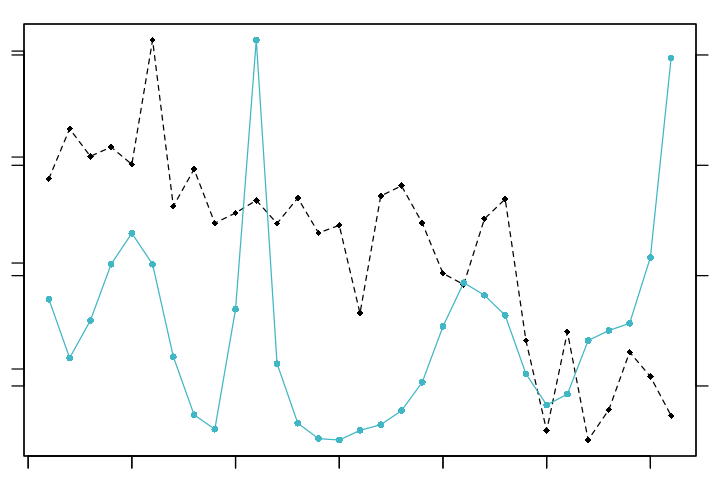

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


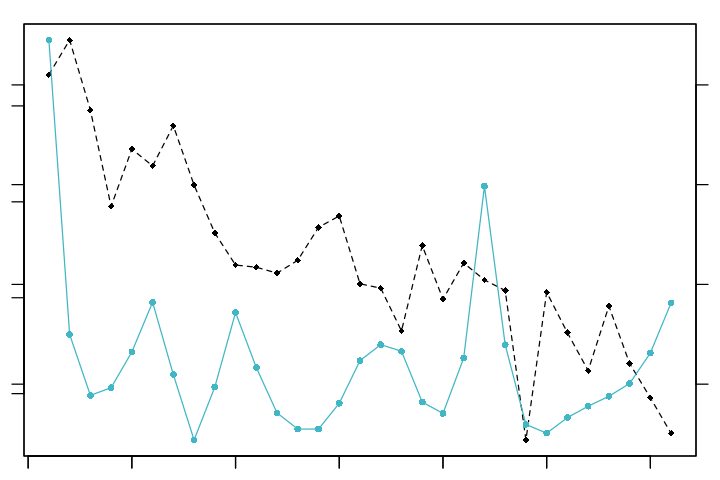

In [298]:
## split seurat object by sequencing run and run doubletfinder
options(repr.plot.width=6, repr.plot.height= 4)
obj_list <- SplitObject(obj, split.by = "samples")
for(x in 1:length(obj_list)){
    obj_list[[x]] <- run_doubletfinder(
        obj_list[[x]], 
        dims = 1:10, 
        truth = "MULTI.global", 
        cluster = "seurat_clusters", 
        dbr = 0.064, 
        ncores = 30)}

In [299]:
## merge seurat objects back to a single seurat object
obj <- merge(obj_list[[1]], obj_list[2:length(obj_list)])
DefaultAssay(obj) <- "RNA"
obj[["RNA"]] <- JoinLayers(obj[["RNA"]])
obj

An object of class Seurat 
17895 features across 15729 samples within 3 assays 
Active assay: RNA (17697 features, 2000 variable features)
 3 layers present: scale.data, data, counts
 2 other assays present: HTO, ADT

Finding variable features for layer counts

Transposing data matrix

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


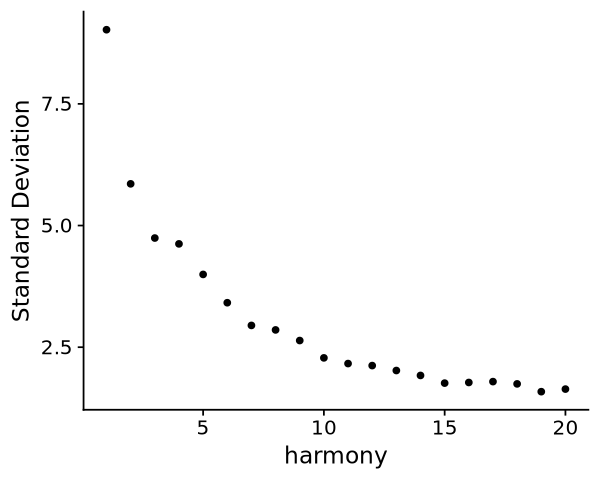

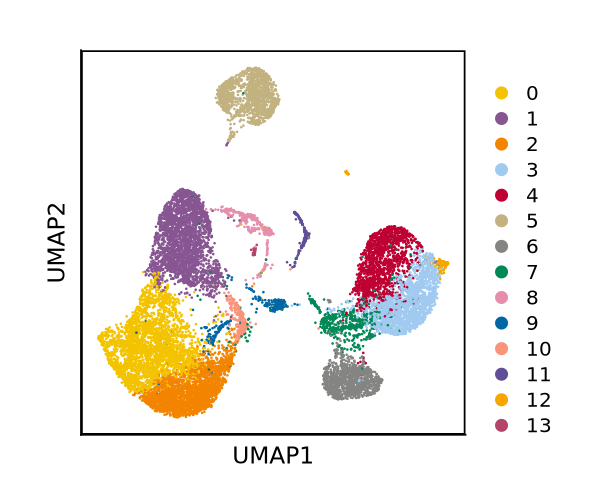

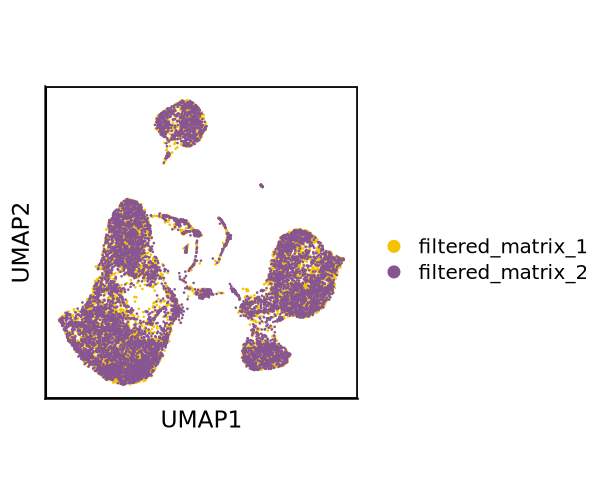

In [300]:
## repeat seurat processing as scDblFinder
options(repr.plot.width=5, repr.plot.height= 4)
obj <- process_seurat(obj, dims = 1:10, harmony = T, group.by.vars = "samples")

Below we visualize the outputs of DoubletFinder with MULTIseqDemux cell demultiplexing outputs and known characteristics of doublets (high nCount_RNA/HTO).

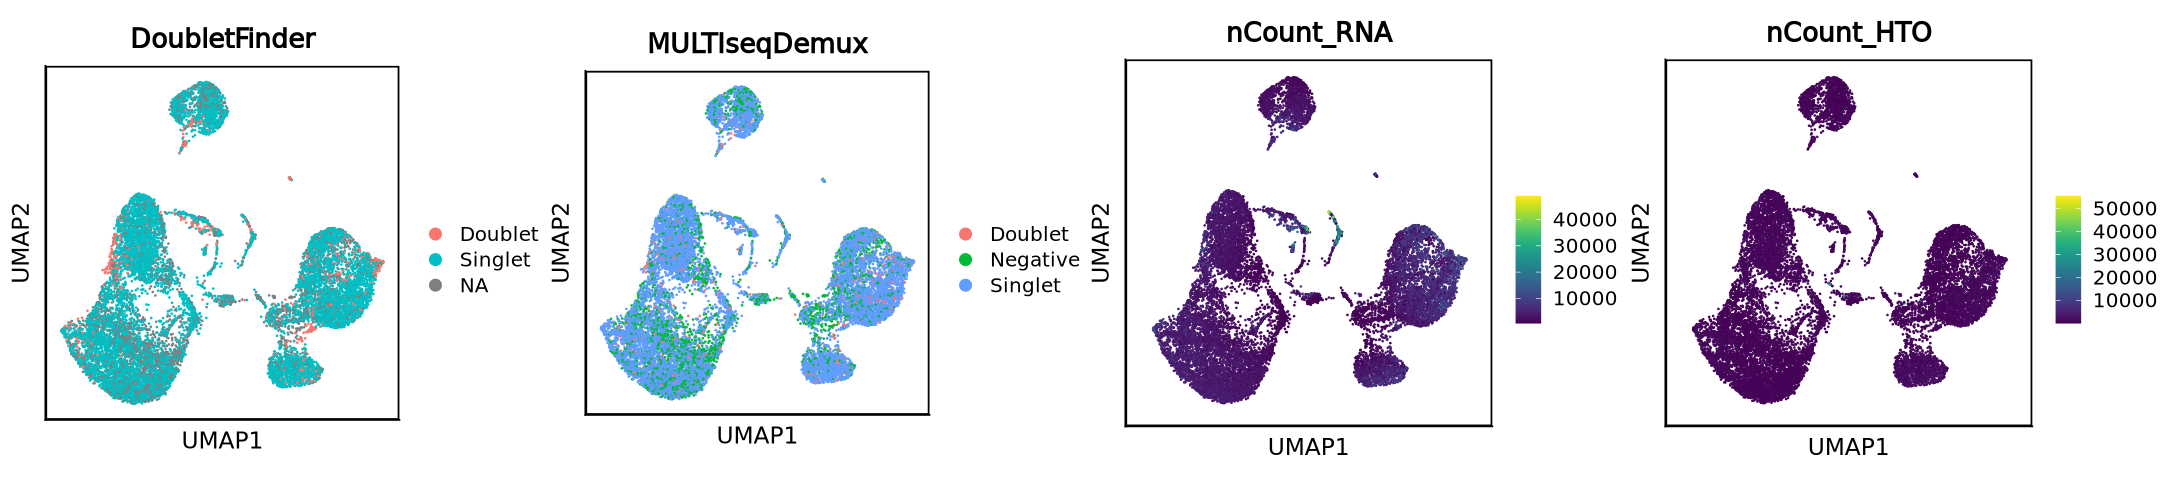

In [301]:
## Visualize doubletfinder output with multiseq demux and nCount_RNA/HTO
options(repr.plot.width=18, repr.plot.height= 4)
plist <- list(scUMAP(obj, reduction = "umap", group.by = "DoubletFinder") + ggtitle("DoubletFinder"))
plist[[2]] <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global") + ggtitle("MULTIseqDemux")
plist[3:4] <- scFeaturePlot(obj, reduction = "umap", features = c("nCount_RNA", "nCount_HTO"), ncol = 2)
plot_grid(plotlist = plist, ncol = 4)

> Compare to the cell demultiplexing outputs, DoubletFinder detects and extra 745 doublets based on transcriptomic profile.

In [302]:
## Compare cell multiplexing output (truth) to doubletfinder output (call)
table(truth=obj$MULTI.global, call=obj$DoubletFinder)

          call
truth      Doublet Singlet
  Doublet      135     487
  Negative       0       0
  Singlet      745   10943

> DoubletFinder found 5.6% doublets (880 cells) across the 2 sequencing runs.

In [312]:
## no. / percentage of doublets
no <- length(which(obj$DoubletFinder == "Doublet"))
no
paste0(round(no*100/ncol(obj), 1), "%")

[1] 880

[1] "5.6%"

Visualizing quality control parameters for singlets and doublets detected by DoubletFinder.

> Similar to scDblFinder, doublets detected in DoubletFinder have higher nFeature_RNA & nCount_RNA than singlets, reflecting the nature of true doublets.

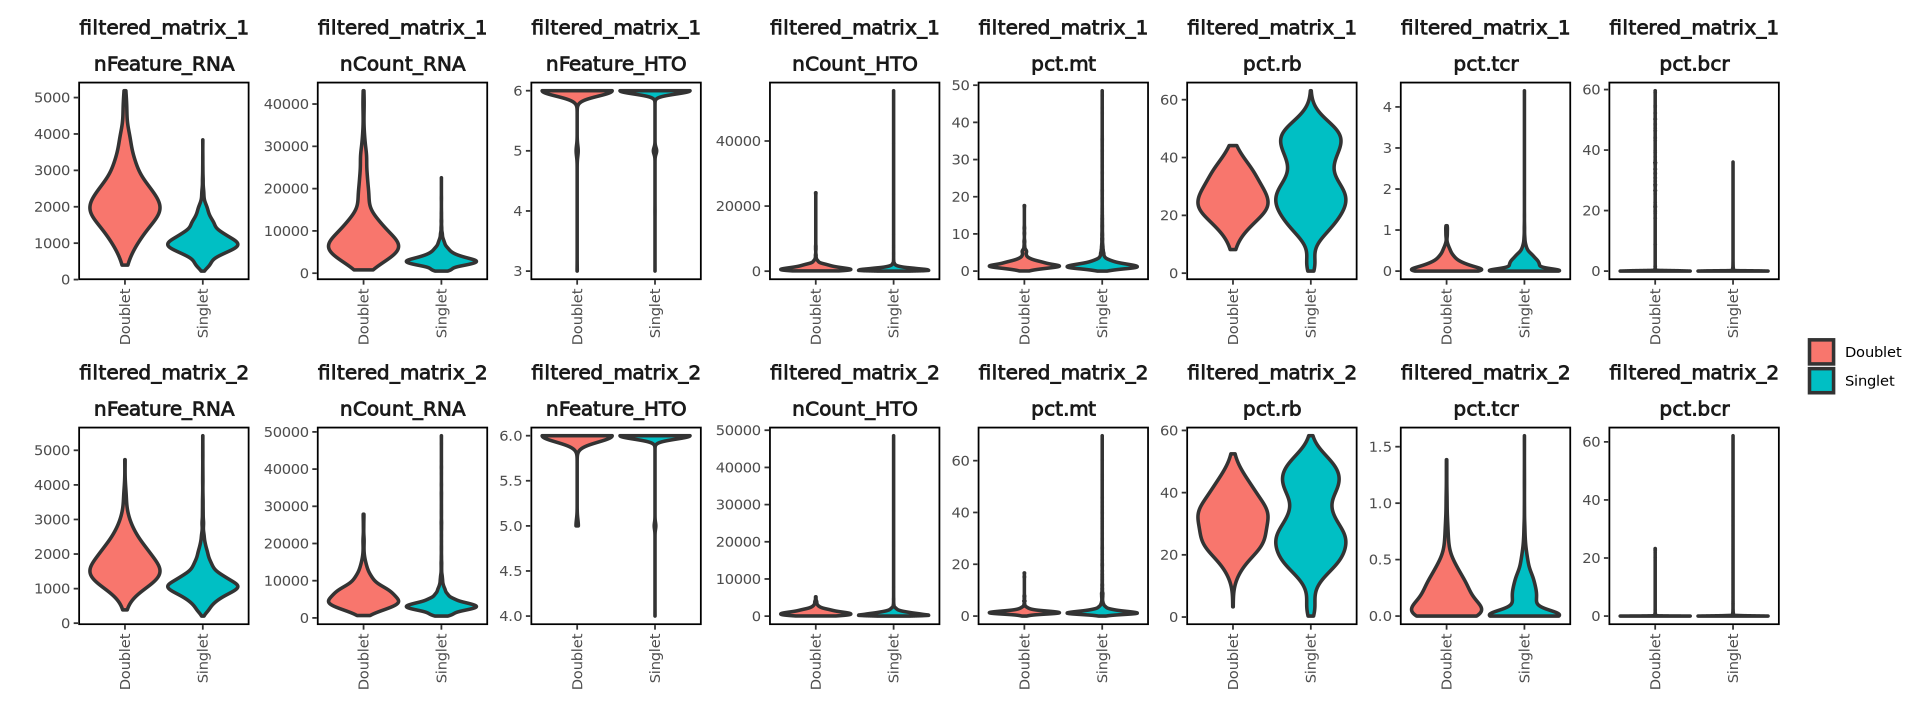

In [303]:
## Visualize qc metrics for doublets detected by DoubletFinder
options(repr.plot.width=16, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    filter(!is.na(DoubletFinder)) %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = DoubletFinder, y = values, fill = DoubletFinder)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## T/B-cell Doublets
T/B-cells represent the most abundant of immune cell populations and have a high chance to be sequenced together as doublets. T and B-cells can be characterized by TCR-VDJ and BCR-VDJ gene expression respectively, the TCR/BCR expressions are mutually exclusive. Therefore T/B-cell doublets can be manually identified and removed if the TCR/BCR fraction is high.

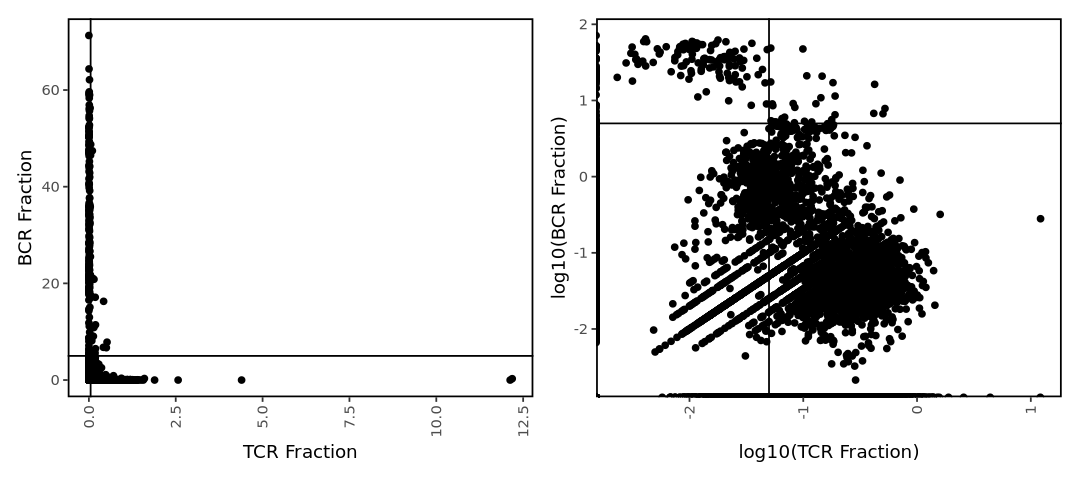

In [6]:
## visualize BCR/TCR read fractions
options(repr.plot.width=9, repr.plot.height= 4)
p1 <- obj@meta.data %>%
    ggplot(aes(x = pct.tcr, y = pct.bcr)) +
    geom_point() +
    theme_border() +
    geom_hline(yintercept = 5) +
    geom_vline(xintercept = 0.05) +
    xlab("TCR Fraction") +
    ylab("BCR Fraction")
p2 <- obj@meta.data %>%
    ggplot(aes(x = log10(pct.tcr), y = log10(pct.bcr))) +
    geom_point() +
    theme_border() +
    geom_hline(yintercept = log10(5)) +
    geom_vline(xintercept = log10(0.05)) +
    xlab("log10(TCR Fraction)") +
    ylab("log10(BCR Fraction)")
p1 + p2

> Judging from the plot above, we have called T/B-cell doublets if TCR fraction is > 0.05% and BCR > 5%

In [7]:
## manually set TCR/BCR fraction threshold
obj@meta.data <- obj@meta.data %>%
    mutate(TB_Doublet = ifelse(pct.tcr > 0.05 & pct.bcr > 5, "Doublet", "Singlet"))

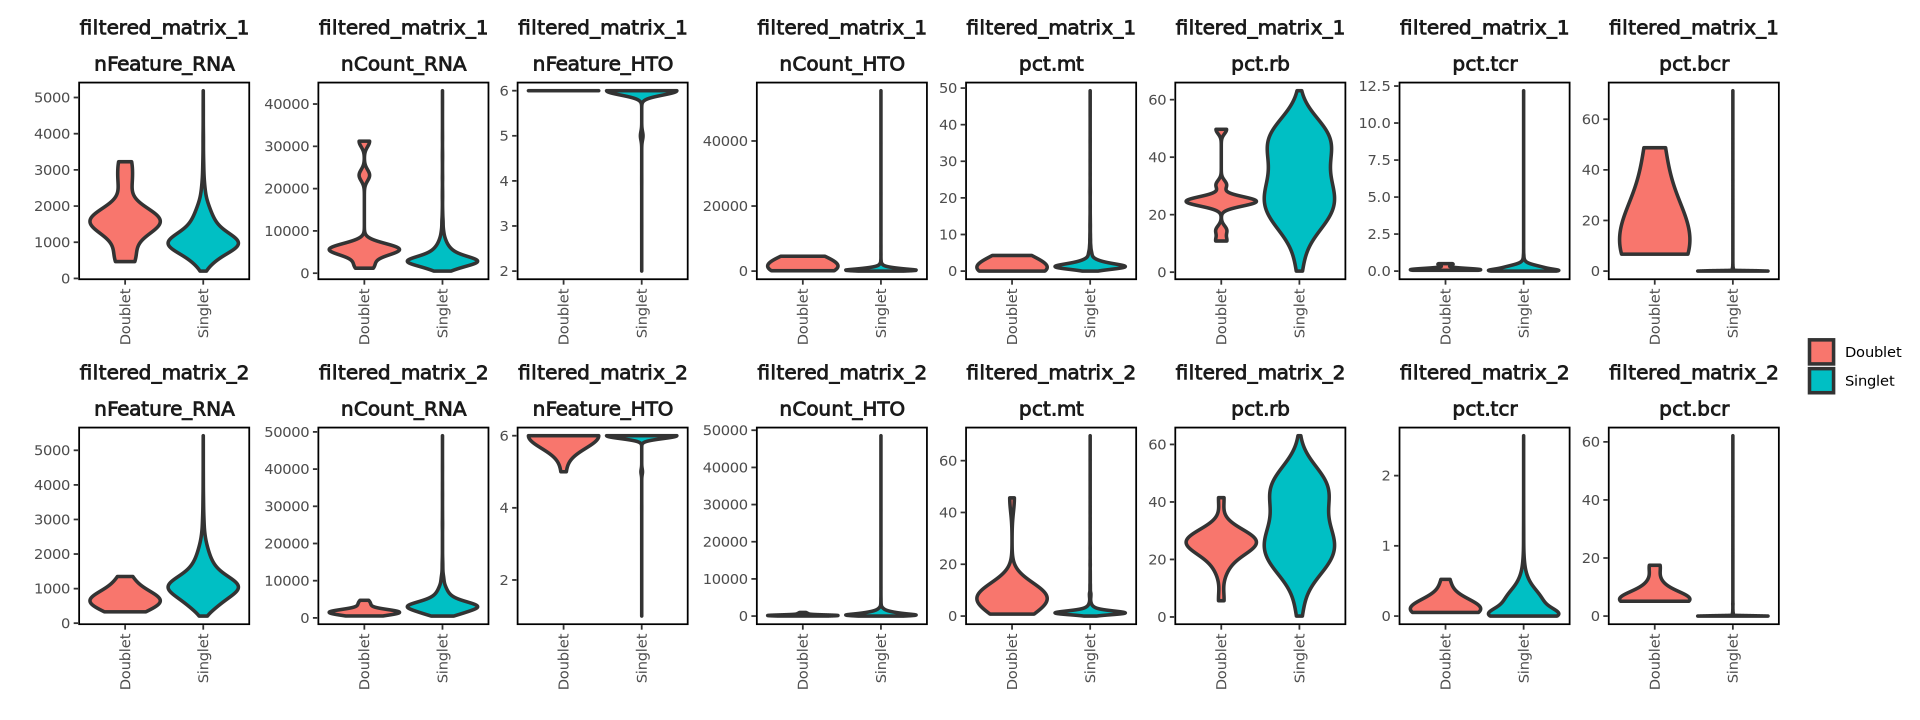

In [19]:
## Visualize qc metrics for TB doublets
options(repr.plot.width=16, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = TB_Doublet, y = values, fill = TB_Doublet)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 3) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## Evaluating Outputs
scDblFinder and DoubletFinder are both able to predict heterolytic doublets with characteristics reflective of true doublet nature. From the UMAP projections below, you can see the outputs from the 2 algorithms are highly consistent with each other.

> The small cluster of cells circled on the UMAP below are highly likely to be real doublets given the cell number, which is only detected by DoubletFinder and not scDblFinder. Therefore, for the following chapters, we will continue using outputs from DoubletFinder.

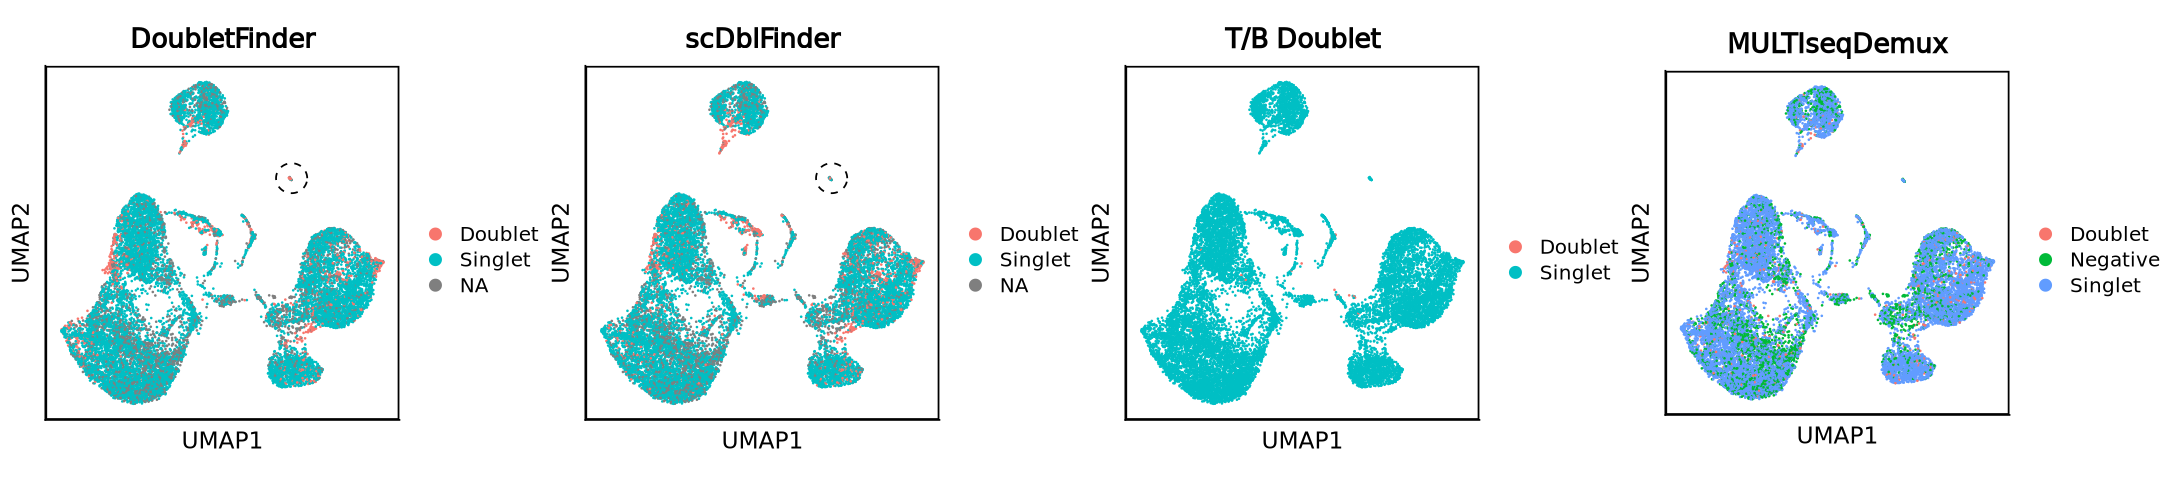

In [11]:
options(repr.plot.width=18, repr.plot.height= 4)
r = 1
xc = 5.5
yc = 7.5
plist <- list(scUMAP(obj, reduction = "umap", group.by = "DoubletFinder") + 
    ggtitle("DoubletFinder") +
    annotate("path",
        x=xc+r*cos(seq(0,2*pi,length.out=100)),
        y=yc+r*sin(seq(0,2*pi,length.out=100)),
        linetype = "dashed"))
plist[[2]] <- scUMAP(obj, reduction = "umap", group.by = "scDblFinder") + 
    ggtitle("scDblFinder") +
    annotate("path",
        x=xc+r*cos(seq(0,2*pi,length.out=100)),
        y=yc+r*sin(seq(0,2*pi,length.out=100)),
        linetype = "dashed")
plist[[3]] <- scUMAP(obj, reduction = "umap", group.by = "TB_Doublet") + ggtitle("T/B Doublet")
plist[[4]] <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global") + ggtitle("MULTIseqDemux")
plot_grid(plotlist = plist, ncol = 4)

~1/3 of the doublets detected by either algorithms are consistent.

In [12]:
## Compare outputs from scDblFinder and DoubletFinder
table(scDblFinder=obj$scDblFinder, DoubletFinder=obj$DoubletFinder)

           DoubletFinder
scDblFinder Doublet Singlet
    Doublet     548     594
    Singlet     332   10836

## Session Info {.unnumbered}

In [16]:
qsave(obj, file = "seurat/20240826_GSE155224_doublets.qs")

In [17]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nemo/lab/caladod/working/Matthew/.conda/envs/seurat5/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scDblFinder_1.14.0          DoubletFinder_2.0.4        
 [3] BiocParallel_1.36.0         harmony_1.1.0              
 [5] Rcpp_1.0.11                 qs_0.26.3    